In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/amex_complaints_sentiment.csv")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_30312\3814953867.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent_counts.index, y=sent_counts.values, palette=['green','red','gray'])


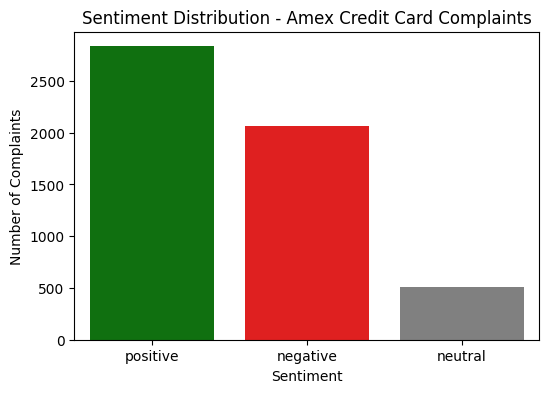

In [162]:
sent_counts = df['sentiment_label'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=sent_counts.index, y=sent_counts.values, palette=['green','red','gray'])
plt.title("Sentiment Distribution - Amex Credit Card Complaints")
plt.xlabel("Sentiment")
plt.ylabel("Number of Complaints")
plt.show()


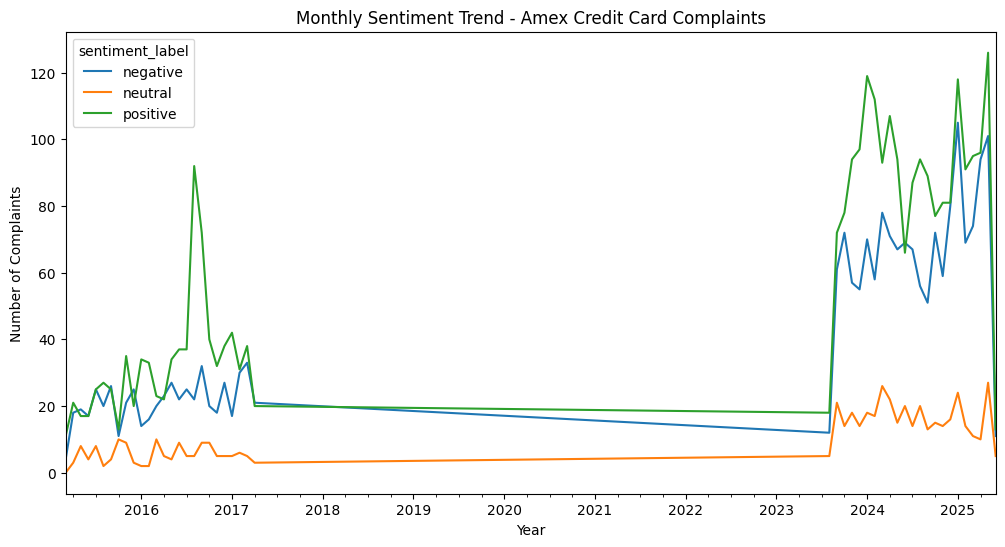

In [163]:
df['date_received'] = pd.to_datetime(df['date_received'])
sent_time = df.groupby([df['date_received'].dt.to_period('M'), 'sentiment_label']).size().unstack(fill_value=0)

sent_time.plot(kind='line', figsize=(12,6))
plt.title("Monthly Sentiment Trend - Amex Credit Card Complaints")
plt.xlabel("Year")
plt.ylabel("Number of Complaints")
plt.show()


In [164]:
df['date_received'] = pd.to_datetime(df['date_received'], errors='coerce')
print(df['date_received'].min(), df['date_received'].max())

print(df['date_received'].dt.year.value_counts().sort_index())

print(df['date_received'].value_counts().head(10))


2015-03-19 00:00:00 2025-06-05 00:00:00
date_received
2015     448
2016     830
2017     251
2023     688
2024    2108
2025    1084
Name: count, dtype: int64
date_received
2024-01-22    19
2025-04-30    16
2025-03-06    15
2025-01-09    15
2024-04-01    15
2024-10-09    15
2025-05-12    15
2025-05-21    15
2025-01-07    14
2024-05-21    14
Name: count, dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_30312\3169724928.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='date_received', freq='M'), 'sentiment_label'])


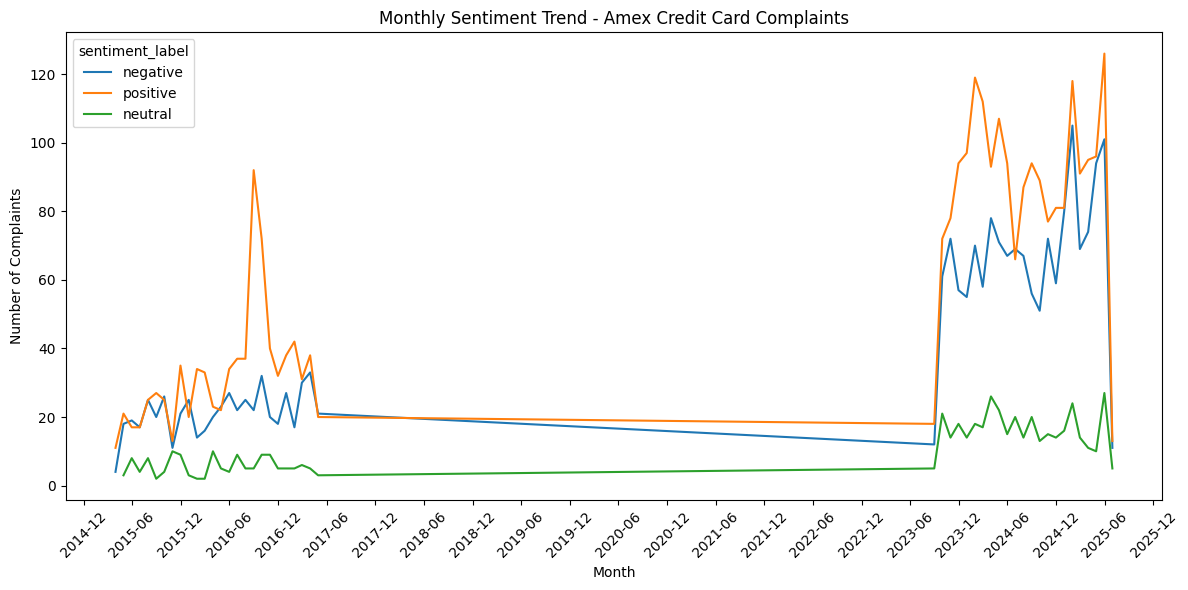

In [165]:
monthly_sentiment = (
    df.groupby([pd.Grouper(key='date_received', freq='M'), 'sentiment_label'])
      .size()
      .reset_index(name='count')
)

monthly_sentiment.rename(columns={'date_received': 'Month'}, inplace=True)

import matplotlib.dates as mdates
plt.figure(figsize=(12, 6))

sns.lineplot(data=monthly_sentiment, x='Month', y='count', hue='sentiment_label')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

plt.title("Monthly Sentiment Trend - Amex Credit Card Complaints")
plt.xlabel("Month")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


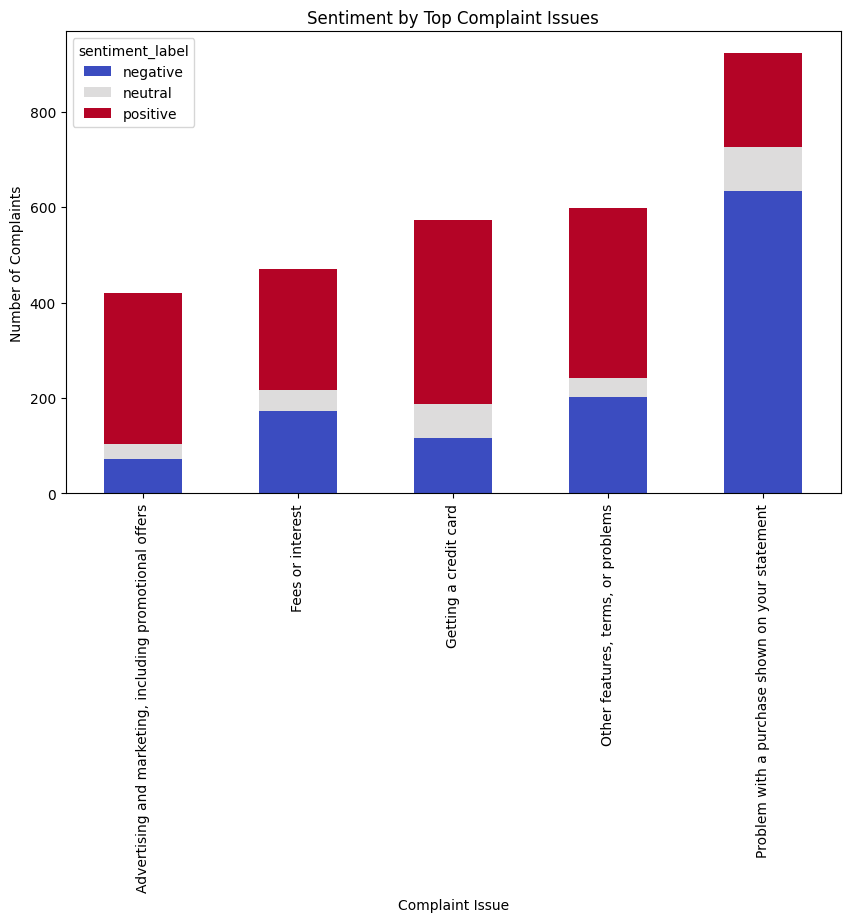

In [166]:
top_issues = df['issue'].value_counts().nlargest(5).index
issue_sent = df[df['issue'].isin(top_issues)].groupby(['issue', 'sentiment_label']).size().unstack()

issue_sent.plot(kind='bar', stacked=True, figsize=(10,6), colormap='coolwarm')
plt.title("Sentiment by Top Complaint Issues")
plt.xlabel("Complaint Issue")
plt.ylabel("Number of Complaints")
plt.show()


In [167]:
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

mask = df['issue'].str.lower().str.contains("other features", na=False)
other_df = df[mask]
print(f"Rows found: {len(other_df)}")

if not other_df.empty:
    text = " ".join(other_df['clean_text'])

    text = re.sub(r'\b[xX]{2,}\b', '', text)

    words = text.split()

    stop_words = set(stopwords.words('english'))

    custom_stopwords = stop_words.union({
        "xxxx", "xxxxxxxx", "american", "express", "credit", "card", "amex", "account"
    })

    filtered_words = [w for w in words if w not in custom_stopwords]

    top_10 = Counter(filtered_words).most_common(10)

    print("\nTop 10 meaningful keywords in 'Other features...' complaints:")
    for word, count in top_10:
        print(f"{word}: {count}")


Rows found: 598

Top 10 meaningful keywords in 'Other features...' complaints:
would: 521
points: 511
time: 348
told: 346
information: 339
payment: 336
customer: 332
received: 308
balance: 306
service: 284


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pd.set_option('display.max_colwidth', None)
false_positives = df[
    (df['sentiment_label'] == 'positive') &
    (df['consumer_complaint_narrative'].str.contains(r'fee|charge|denied|issue|problem|late|fraud|dispute', case=False, na=False))
]

false_positives[['consumer_complaint_narrative', 'vader_sentiment', 'sentiment_label']].sample(5, random_state=42)

,consumer_complaint_narrative,vader_sentiment,sentiment_label
742,"XXXX Card Members can receive a Free Night Award of XXXX XXXX XXXX points after a spend of {$4000.00} or more in qualifying purchases are made on the Card within 4 months of accepting this offer. \nI accepted this offer on XXXX XX/XX/XXXX, so I should have until XXXX XXXX to meet the XXXX dollars requirement, but amex told me Upon reviewing your account, I see the case that was previously submitted. It appears that as per offer terms, the spending threshold is from the offer starting date which was on XXXX until XXXX that's why the spending that was counted was until XXXX only totaling {$3700.00}. \nI spent more than XXXX dollars during the 4 month period, but they don't want to issue the free night.",0.8710,positive
1190,"I am writing to request your assistance in resolving an issue regarding a {$39.00} return payment fee charged to my XXXX XXXX Amex Card. The charge was applied on XX/XX/year>, when the payment of {$1300.00} bounced on XX/XX/year>. {$1300.00} was debited from my bank on XX/XX/year>. \n\nUpon contacting American Express to inquire about this fee, I could not receive a clear explanation as to why the {$39.00} was incurred, especially when the payment was successfully processed later through another system attempt.\n\nThank you for your attention to this issue!",0.6504,positive
3189,I applied for a XXXX American Express card and was told that I would receive XXXX reward points upon me spending {$1000.00} on the card within my first 3 months. prior to me applying for the card I explain to the representative or ask the representative I should say if I would be disqualified for the XXXX reward points because I had previously applied and was a proof for the same card in 2014 but I declined to get the card.I was placed on hold and came back as they told me I would still be eligible for receiving the XXXX reward points upon spending my XXXX thousand dollars since I never got the XXXX card.this information was told to me prior to me giving my approval for American Express to run credit for the card now that I have the card and have used a thousand plus dollars on it and have made payment of that money back they are telling me that I wo n't get the XXXX. I asked why would I not get the XXXX points and they are saying because I had been approved for a previous card.I tried to work this issue out with them. I emailed them and contacted them several times and no one has responded to my emails and the supervisors that I 've spoken with said there 's nothing that they 're going to do with the exception of reprimanding the representative as they will not give me the XXXX points that was promised.I was approved for the card under false pretense a false advertisement from Amex.,0.9753,positive
3557,"Ive been an American Express client since XXXX having credit card and savings accounts with them. My current credit card with them is the XXXX XXXX XXXX, which has an expiration date of XX/XX/XXXX. I also have a high yield savings account with Amex that I opened several years ago. \n\nOn Thursday, XX/XX/XXXX I logged into my American Express app in order to view my rewards points. Unfortunately, once I logged in I was notified that my credit card was cancelled by American Express due to inactivity. Next, I called American Express to find out what happened and whether I could still access my rewards points. The agent told me that my account was closed in XX/XX/XXXX due to inactivity and that my points were forfeited. The agent told me that that they notified me about the closing. I never received any notification about the matter. The agent told me that they didnt have my email address on file but that they sent it to my mailing address. Unfortunately, I never saw the mail notifying me of my account closure. I feel that American Express has wrongly closed my account because it did not adequately notify me about my account closure. Had they done so, I could have made t